In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass
import csv
import numpy as np
import random
import time
from PIL import Image
from imageio import imwrite,imread
import os
from pylablib.devices import Thorlabs
from PIL import Image
import PIL.ImageOps 
import matplotlib.pyplot as plt 
  
from pylablib.devices import Thorlabs
# Function to calculate intensity ratio for image analysis
def analyse_intensity_ratio():
    Thorlabs.list_cameras_tlcam()
    cam = Thorlabs.ThorlabsTLCamera(serial="14308")
    raw_image_array = cam.grab(10)  # grab 10 frames
    image_array = np.array(raw_image_array)
    squeezed_image_array = image_array.squeeze()
    intensity_metrics=[]
    cam.close()
    for i in range(len(squeezed_image_array)):

        y, x = center_of_mass(squeezed_image_array[i])

        # Define a circular region around the centroid
        radius = 20  # Adjust the radius as needed
        yy, xx = np.ogrid[:squeezed_image_array[i].shape[0], :squeezed_image_array[i].shape[1]]
        circle = (yy - y) ** 2 + (xx - x) ** 2 <= radius ** 2

        # Calculate the total intensity inside and outside the circle
        total_intensity_inside = np.sum(squeezed_image_array[i][circle])
        total_intensity_outside = np.sum(squeezed_image_array[i][~circle])

        # Calculate the intensity ratio as a quality metric (normalized to [0, 1])
        intensity_ratio = total_intensity_inside / (total_intensity_inside + total_intensity_outside)
        intensity_ratio_normalized = intensity_ratio / 0.025  # Normalize to a reference value
        intensity_metrics.append(intensity_ratio_normalized)
        
    return np.mean(intensity_metrics)
analyse_intensity_ratio()

0.076087428420831

In [2]:
import numpy as np
import csv
from skopt import gp_minimize
from skopt.space import Integer
from scipy.ndimage import center_of_mass

# Function to set PWM values
def set_PWMs(pwms):
    A = np.array([[pwms[0]], [pwms[1]], [pwms[2]], [pwms[3]], [pwms[4]]]).astype(int)
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    time.sleep(1)
    return 0

# Function to capture images and perform intensity analysis
def capture_and_analyse_intensity(pwm_values):
    set_PWMs(pwm_values)  # Set PWM values
    score = analyse_intensity_ratio()
    # Return the negative mean intensity ratio as the objective function value
    return -score

# Number of PWM parameters
NUM_PARAMETERS = 5

# Define the parameter space for PWM values
param_space = [Integer(0, 4095, name=f'PWM_{i}') for i in range(NUM_PARAMETERS)]

# Run Bayesian optimization
result = gp_minimize(capture_and_analyse_intensity, param_space, n_calls=11, random_state=42, n_jobs=1)

# Print the best parameters and corresponding quality
best_params = result.x
best_quality = -result.fun  # Remember to negate the score because skopt performs minimization
print("Best Parameters:", best_params)
print("Best Quality:", best_quality)


Best Parameters: [2786, 1845, 54, 3858, 2307]
Best Quality: 0.16170732984465894


Best Parameters: [409, 1881, 1367, 585, 2665]
Best Quality: 0.11289489557888785


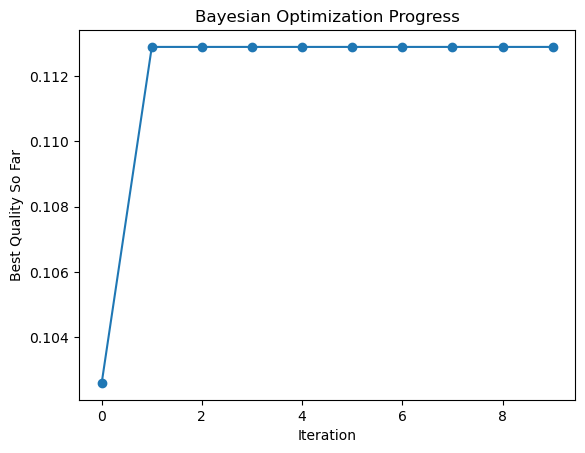

In [3]:

import numpy as np
import csv
import matplotlib.pyplot as plt
import time
from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args  # Import the use_named_args decorator

# Function to set PWM values
def set_PWMs(pwms):
    A = np.array([[pwms[0]], [pwms[1]], [pwms[2]], [pwms[3]], [pwms[4]]]).astype(int)
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    time.sleep(0.5)
    return 0

# Function to capture images and perform intensity analysis
def capture_and_analyse_intensity(pwm_values):
    set_PWMs(pwm_values)  # Set PWM values
    score = analyse_intensity_ratio()
    # Return the negative mean intensity ratio as the objective function value
    return -score

# Number of PWM parameters
NUM_PARAMETERS = 5

# Define the parameter space for PWM values
param_space = [Integer(0, 4095, name=f'PWM_{i}') for i in range(NUM_PARAMETERS)]

# Run Bayesian optimization and track best quality
best_quality_history = []

@use_named_args(param_space)
def objective_function(**params):
    pwm_values = np.array(list(params.values())).reshape(-1, 1)
    quality = capture_and_analyse_intensity(pwm_values)
    best_quality_history.append(-quality)  # Track best quality
    return quality

# Run Bayesian optimization
result = gp_minimize(objective_function, param_space, n_calls=10, random_state=42, n_jobs=1)

# Print the best parameters and corresponding quality
best_params = result.x
best_quality = -result.fun  # Remember to negate the score because skopt performs minimization
print("Best Parameters:", best_params)
print("Best Quality:", best_quality)

# Plot the best quality so far against iteration
best_quality_so_far = np.maximum.accumulate(best_quality_history)
plt.plot(best_quality_so_far, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Best Quality So Far')
plt.title('Bayesian Optimization Progress')
plt.show()


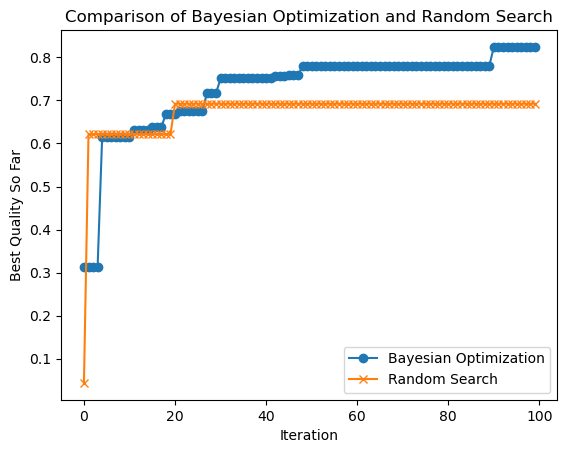

In [4]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import time
from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args

# Function to set PWM values
def set_PWMs(pwms):
    A = np.array([[pwms[0]], [pwms[1]], [pwms[2]], [pwms[3]], [pwms[4]]]).astype(int)
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    time.sleep(0.5)
    return 0

# Function to capture images and perform intensity analysis
def capture_and_analyse_intensity(pwm_values):
    set_PWMs(pwm_values)  # Set PWM values
    score = analyse_intensity_ratio()
    # Return the negative mean intensity ratio as the objective function value
    return -score

# Number of PWM parameters
NUM_PARAMETERS = 5

# Initial parameter values for both BO and Random Search
initial_params = [1000, 1000, 1000, 1000, 1000]

# Parameter space for PWM values
param_space = [Integer(0, 4095, name=f'PWM_{i}') for i in range(NUM_PARAMETERS)]

# Bayesian Optimization
# Run Bayesian optimization and track best quality
best_quality_history_bo = []

@use_named_args(param_space)
def objective_function_bo(**params):
    pwm_values = np.array(list(params.values())).reshape(-1, 1)
    quality = capture_and_analyse_intensity(pwm_values)
    best_quality_history_bo.append(-quality)  # Track best quality
    return quality

# Run Bayesian optimization with the same initial set
result_bo = gp_minimize(objective_function_bo, param_space, x0=initial_params, n_calls=100, n_jobs=1)

# Random Search
# Run Random Search and track best quality
np.random.seed(42)
num_random_samples = 100
best_quality_history_random = []

for _ in range(num_random_samples):
    random_params = {f'PWM_{i}': np.random.randint(0, 4096) for i in range(NUM_PARAMETERS)}
    quality = capture_and_analyse_intensity(np.array(list(random_params.values())).reshape(-1, 1))
    best_quality_history_random.append(-quality)  # Track best quality

# Plot the best quality so far against iteration for both methods
best_quality_so_far_bo = np.maximum.accumulate(best_quality_history_bo)
best_quality_so_far_random = np.maximum.accumulate(best_quality_history_random)

plt.plot(best_quality_so_far_bo, label='Bayesian Optimization', marker='o')
plt.plot(best_quality_so_far_random, label='Random Search', marker='x')
plt.xlabel('Iteration')
plt.ylabel('Best Quality So Far')
plt.title('Comparison of Bayesian Optimization and Random Search')
plt.legend()
plt.show()

In [5]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import time
from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args

# Function to set PWM values
def set_PWMs(pwms):
    A = np.array([[pwms[0]], [pwms[1]], [pwms[2]], [pwms[3]], [pwms[4]]]).astype(int)
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    time.sleep(0.5)
    return 0

# Function to capture images and perform intensity analysis
def capture_and_analyse_intensity(pwm_values):
    set_PWMs(pwm_values)  # Set PWM values
    score = analyse_intensity_ratio()
    # Return the negative mean intensity ratio as the objective function value
    return -score

# Number of PWM parameters
NUM_PARAMETERS = 5

# Initial parameter values for both BO and Random Search
initial_params = [1000, 1000, 1000, 1000, 1000]

# Parameter space for PWM values
param_space = [Integer(0, 4095, name=f'PWM_{i}') for i in range(NUM_PARAMETERS)]

# Run the comparison 5 times
num_runs = 15
best_quality_history_bo_all = []
best_quality_history_random_all = []

for _ in range(num_runs):
    # Bayesian Optimization
    best_quality_history_bo = []

    @use_named_args(param_space)
    def objective_function_bo(**params):
        pwm_values = np.array(list(params.values())).reshape(-1, 1)
        quality = capture_and_analyse_intensity(pwm_values)
        best_quality_history_bo.append(-quality)  # Track best quality
        return quality

    result_bo = gp_minimize(objective_function_bo, param_space, x0=initial_params, n_calls=250, n_jobs=1)
    best_quality_history_bo_all.append(np.maximum.accumulate(best_quality_history_bo))
    
    # Random Search
    np.random.seed(42)
    num_random_samples = 250

    best_quality_history_random = []

    for _ in range(num_random_samples):
        random_params = {f'PWM_{i}': np.random.randint(0, 4096) for i in range(NUM_PARAMETERS)}
        quality = capture_and_analyse_intensity(np.array(list(random_params.values())).reshape(-1, 1))
        best_quality_history_random.append(-quality)  # Track best quality

    best_quality_history_random_all.append(np.maximum.accumulate(best_quality_history_random))



C:\Users\plasma\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\plasma\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\plasma\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\plasma\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\plasma\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\p

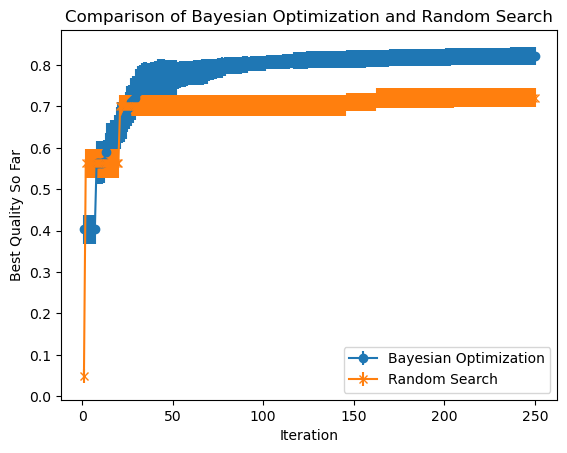

In [6]:
# Calculate mean and standard deviation
mean_bo = np.mean(best_quality_history_bo_all, axis=0)
std_bo = np.std(best_quality_history_bo_all, axis=0)
mean_random = np.mean(best_quality_history_random_all, axis=0)
std_random = np.std(best_quality_history_random_all, axis=0)

# Plot the results with error bars
plt.errorbar(range(1, 251), mean_bo, yerr=std_bo, label='Bayesian Optimization', marker='o')
plt.errorbar(range(1, 251), mean_random, yerr=std_random, label='Random Search', marker='x')
plt.xlabel('Iteration')
plt.ylabel('Best Quality So Far')
plt.title('Comparison of Bayesian Optimization and Random Search')
plt.legend()
plt.show()